<p>
<center>
<sup><strong>
<h1>
Analysis of SEM Images of Steel
</h1>
</strong></sup>
</center>
</p>

<p>
<ul>

<li style="float: left; display: inline">
<a href="https://travis-ci.org/wd15/sem-image-stats" target="_blank">
<img src="https://api.travis-ci.org/wd15/sem-image-stats.svg"
alt="Travis CI">
</a>
</li>

<li style="float: left; display: inline">
<a href="https://github.com/wd15/sem-images-stats/blob/master/LICENSE.md" target="_blank">
<img src="https://img.shields.io/badge/license-mit-blue.svg"
alt="Travis CI">
</a>
</li>

</ul>
</p>
<br>

### Overview

The goal of this work is to analyze images of steel from SEM. The initial data set consists of 9 images. The first step in the work (comprising this notebook) is to categorize the microstructure in each image. A number of analysis steps are required including

 - cropping the images,
 - extracting meta-data embedded in the images,
 - thresholding the images to increase contrast,
 - classifying the pixels in the image as a given phase,
 - classifying the inter lammelar spacing in one of the phases,
 - obtaining statistics about the microstructure such as the volume fraction, spacing and shape.

### Git LFS

The image files are stored in Git using Git Large File Storage. This is an exploratory attempt at using Git LFS. Future work with very large volumes of data will require a public server with Git LFS deployed as the current work uses GitHub as the Git LFS server, which only allows 2GB of data storage for each user.

### Toolz

This analysis uses [Toolz](http://toolz.readthedocs.io/en/latest/) to explore the use of functional programming for data pipelines in Python. It seems to make the code a lot cleaner with less intermediate variables, which seems to be an advantage especially when evaluating cells in the notebook. Overall, it is currently unclear how much of benefit this approach provides. It does seem to obfuscate some of the code for non-functional programmers. Hopefully, it will help with parallel processing of the data pipelines using Dask in the future.

### Reproducible

The notebook is tested on Travis CI so the computational environment can be built by following the steps in `.travis.yml`.

In [37]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get, do, curry, count, pluck
import pandas
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu

 ## Helper Functions

`fcompose` is a helper function that doesn't seem to be in Toolz, but seems to make writing function pipelines much easier, likewise, when working with lists of dictionaries and data frames, `mapdict` and `dfassing` seem useful.

In [38]:
fcompose = lambda *args: compose(*args[::-1])

mapdict = lambda **kwargs: map(lambda data: dict(**dict((k, f(data)) for k, f in kwargs.items()),
                                                 **data))

@curry
def dfassign(df, **kwargs):
    return df.assign(**dict(((k, f(df)) for k, f in kwargs.items())))


## View the Images

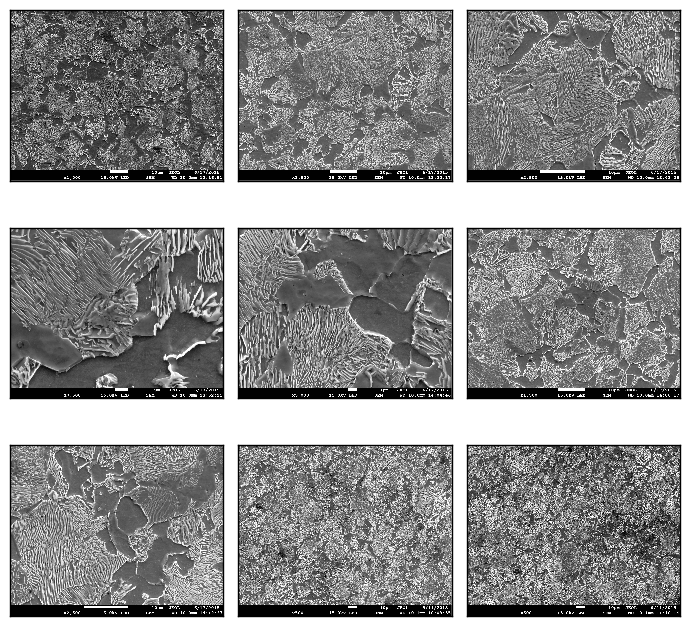

In [39]:
reshape = lambda arr: arr if len(arr.shape) == 2 else arr[...,0]
to_array = lambda image: reshape(np.asarray(image.convert("L")))

def plt_arrays(arrs):
    fig = plt.figure(figsize=(7, 7))
    N = int(np.ceil(np.sqrt(len(arrs))))
    for i, arr in enumerate(arrs):
        ax = fig.add_subplot(N, N, i + 1)
        out = ax.imshow(arr, cmap='Greys_r', interpolation='none')
        out.axes.get_xaxis().set_visible(False)
        out.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(to_array),
    list,
    plt_arrays
)

## Extract the Metadata

Each image has metadata embedded in the image. Here, `pytesseract` is used to extract this data. The images are cropped to split them into two upper and lower sections. The text extraction works better without the microstructure noise.

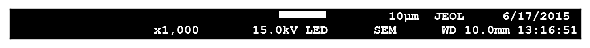

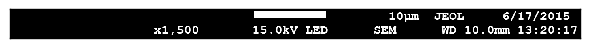

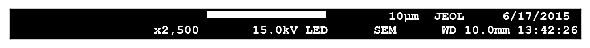

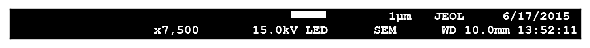

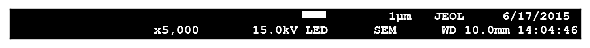

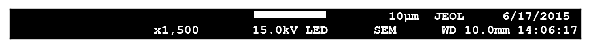

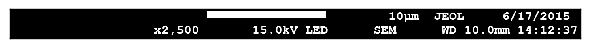

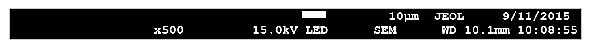

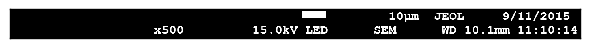

In [40]:
@curry
def crop_image(image, cutoff=960):
    return dict(
               upper=image.crop(box=(0, 0, image.size[0], cutoff)),
               lower=image.crop(box=(0, cutoff, image.size[0], image.size[1]))
           )

def plt_array(arr):
    ax = plt.imshow(arr, cmap='Greys_r', interpolation='none')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(crop_image),
    pluck('lower'),
    map(to_array),
    map(
        do(
            plt_array
        )
    ),
    list
)

The metadata required from the images is the scale of the images. This requires the real scale size given by the number to the right of the scale bar and the size of the scale bar in pixels.

In [42]:
repair_string = lambda string: float('10' if string == 'mum' else string.replace('pm', ''))

scale_pixels = fcompose(
    to_array,
    lambda data: label(data, background=0),
    regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1]
)

extract_strings = fcompose(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
    get([1, 3, -1]),
    lambda data: dict(scale_microns=repair_string(data[0]),
                      date=data[1].replace('-', ''),
                      time=data[2])
)

extract_metadata = fcompose(
    PIL.Image.open,
    crop_image,
    get('lower'),
    lambda image: dict(scale_pixels=scale_pixels(image), **extract_strings(image))
)

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename, **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame
)

print(out)

        date                            filename  scale_microns  scale_pixels  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif           10.0           107   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif           10.0           161   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif           10.0           267   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif            1.0            80   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif            1.0            54   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif           10.0           161   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif           10.0           267   
7  9/11/2015   data/20150911_1045_Nital_etch.tif           10.0            54   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif           10.0            54   

       time  
0  13:16:51  
1  13:20:17  
2  13:42:26  
3  13:52:11  
4  14:04:46  
5  14:06:17  
6  14:12:37  
7  10:08:55  
8  11:10:14  


## Rescale the Images

An array data point needs to have the same representation across all the images. This is done by rescaling the all the images to have the scale of the coarsest sampling.

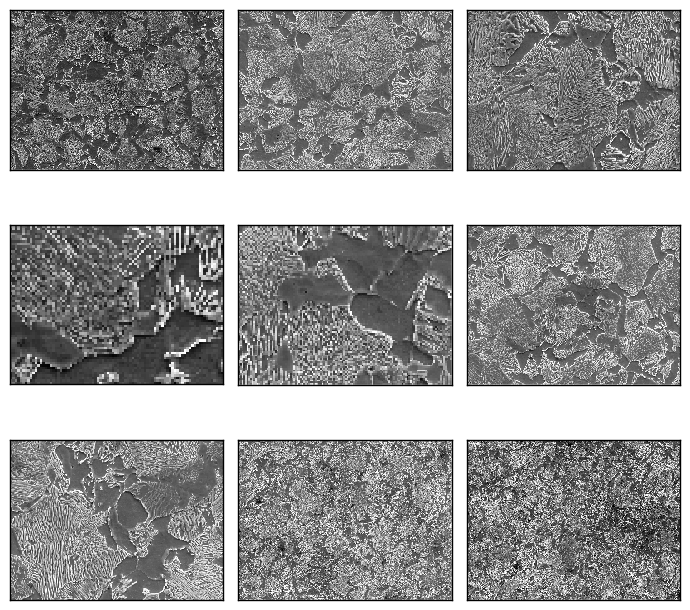

In [43]:
extract_image = fcompose(
    PIL.Image.open,
    crop_image,
    get('upper')
)

def scale_image(image, rescale_factor):
    copy_image = image.copy()
    copy_image.thumbnail(np.array(copy_image.size) * rescale_factor, PIL.Image.ANTIALIAS)
    return copy_image

mapdict = lambda **kwargs: map(lambda data: dict(**dict((k, f(data)) for k, f in kwargs.items()),
                                                 **data))

@curry
def dfassign(df, **kwargs):
    return df.assign(**dict(((k, f(df)) for k, f in kwargs.items())))

get_df = fcompose(
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename,
                              **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame,
    dfassign(pixel_size=lambda df: df['scale_microns'] / df['scale_pixels']),
    dfassign(rescale_factor=lambda df: df['pixel_size'] / max(df['pixel_size'])),
)

scaled_images = fcompose(
    get_df,
    lambda df: df.T.to_dict().values(),
    mapdict(image=lambda data: extract_image(data['filename'])),
    mapdict(scaled_image=lambda data: scale_image(data['image'], data['rescale_factor'])),
    list
)

out = pipe(
    'data/*.tif',
    scaled_images,
    pluck('scaled_image'),
    map(to_array),
    list,
    plt_arrays
)

## Evaluate the Threshold Value

In [22]:
extract_threshold = fcompose(
    crop,
    get(0),
    np.array,
    threshold_otsu
)

thresh = fcompose(
    lambda df: df['filename'],
    map(extract_threshold),
    lambda data: dict(threshold=list(data)),
    pandas.DataFrame
)

make_df_thresh = fcompose(
    make_df,    
    lambda df: pandas.concat([df, thresh(df)], axis=1)
)

print(make_df_thresh('data/*.tif'))

        date                            filename  scale  scale_pixels  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif   10.0           107   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif   10.0           161   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif   10.0           267   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif    1.0            80   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif    1.0            54   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif   10.0           161   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif   10.0           267   
7  9/11/2015   data/20150911_1045_Nital_etch.tif   10.0            54   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif   10.0            54   

       time  threshold  
0  13:16:51         98  
1  13:20:17        123  
2  13:42:26        118  
3  13:52:11        112  
4  14:04:46        115  
5  14:06:17        131  
6  14:12:37        129  
7  10:08:55        131  
8  11:10:14        120  


/home/dwheeler/anaconda/lib/python3.5/site-packages/skimage/filters/thresholding.py:132: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (960, 1280, 3) looks like an RGB image
  warn(msg.format(image.shape))


## Threshold the Images

/home/dwheeler/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


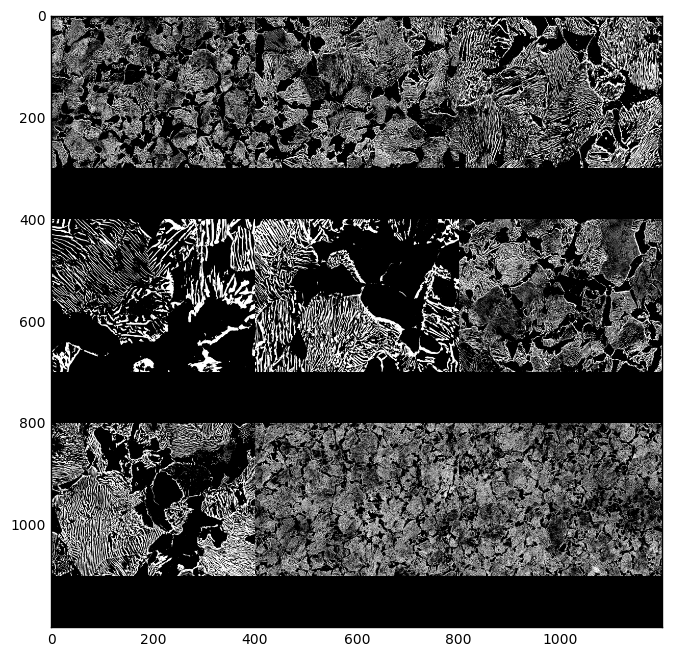

In [20]:
thresh_image = fcompose(
    crop,
    get(0),
    np.array,
    lambda data: data if len(data.shape) == 2 else data[...,0],
    lambda data: (data > threshold_otsu(data)).astype(float)
)

thresh_images = fcompose(
    lambda df: df['filename'],
    map(thresh_image),
)

to_pil = lambda data: PIL.Image.fromarray(np.uint8(data * 255))

make_thumb = fcompose(
    make_df,
    thresh_images,
    map(to_pil),
    list,
    combine_image(1200),
    np.array
)


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(make_thumb("data/*.tif"))
fig.tight_layout()
fig.show()

